In [1]:
import os 
import csv
import nltk
import heapq
import gensim
import string
import itertools

from operator import itemgetter

## Data Loading 

Loads the corpus from a CSV file containing metadata and abstracts about the paper, then performs some lightweight tokenization of the abstracts in the corpus. 

In [2]:
DATA = "data/ieee-xplore.csv"

def load_data(path=DATA):
    with open(path, 'r') as f:
        reader = csv.DictReader(f) 
        for row in reader:
            row['Tokenized Abstract'] = tokenize(row['Abstract'])
            yield row
        

def tokenize(text):
    return [
        list(nltk.wordpunct_tokenize(sent))
        for sent in nltk.sent_tokenize(text)
    ]

corpus = list(load_data())

In [3]:
corpus[0].keys()

odict_keys(['Document Title', 'Authors', 'Author Affiliations', 'Publication Title', 'Date Added To Xplore', 'Publication_Year', 'Volume', 'Issue', 'Start Page', 'End Page', 'Abstract', 'ISSN', 'ISBNs', 'DOI', 'Funding Information', 'PDF Link', 'Author Keywords', 'IEEE Terms', 'INSPEC Controlled Terms', 'INSPEC Non-Controlled Terms', 'Mesh_Terms', 'Article Citation Count', 'Reference Count', 'Copyright Year', 'License', 'Online Date', 'Issue Date', 'Meeting Date', 'Publisher', 'Document Identifier', '', 'Tokenized Abstract'])

## Key Phrase Extraction 

Extract key phrases from abstracts/documents ranked by TF-IDF

In [4]:
PUNCT     = set(string.punctuation)
STOPWORDS = set(nltk.corpus.stopwords.words('english'))
GRAMMAR   = r'KT: {(<JJ>* <NN.*>+ <IN>)? <JJ>* <NN.*>+}'
GOODTAGS  = set(['JJ','JJR','JJS','NN','NNP','NNS','NNPS'])


def candidates(abstract, chunks=True, grammar=GRAMMAR, tags=GOODTAGS):
    """
    Extracts the candidate terms (chunks or individual workds).
    """
    tagged = nltk.pos_tag_sents(abstract)

    if chunks:
        # Extract candidate chunks
        chunker = nltk.chunk.regexp.RegexpParser(grammar)
        chunks  = list(itertools.chain.from_iterable(
            nltk.chunk.tree2conlltags(chunker.parse(sent))
            for sent in tagged
        ))

        def object_filter(group):
            word, pos, chunk = group
            return chunk != 'O'

        # Rejoin candidates as text
        candidates = [
            " ".join(word for word, pos, chunk in group).lower()
            for key, group in itertools.groupby(chunks, object_filter) if key
        ]

        # Filter stopwords and puntuation
        return [
            cand for cand in candidates
            if (
                cand not in STOPWORDS and
                not all(char in PUNCT for char in cand))
        ]

    else:
        tagged = itertools.chain.from_iterable(tagged)

        # Return lower case and filtered words
        return [
            word.lower() for word, tag in tagged
            if (
                tag in tags and word.lower() not in STOPWORDS
                and not all(char in PUNCT for char in word)
            )
        ]


def score_keyphrases_by_tfidf(texts, fileids, N=20):
    """
    Computes the TF-IDF scoring of the corpus given a list of lists of
    candidate terms where each list represents a single document.
    """

    id2word = gensim.corpora.Dictionary(texts)
    corpus  = [id2word.doc2bow(text) for text in texts]
    tfidf   = gensim.models.TfidfModel(corpus)
    scored  = tfidf[corpus]

    output  = []
    for idx, doc in enumerate(scored):
        output.append(u"Document '{}' key phrases:".format(fileids[idx]))

        # Get the top N terms by TF-IDF score
        for wid, score in heapq.nlargest(N, doc, key=itemgetter(1)):
            output.append(u"{:0.3f}: {}".format(score, id2word[wid]))

        output.extend([u'',u''])

    return u"\n".join(output)

In [6]:
fileids = [doc['Document Title'] for doc in corpus]
with open('data/keyphrases.txt', 'w') as f:
    f.write(
        score_keyphrases_by_tfidf([candidates(doc['Tokenized Abstract']) for doc in corpus], fileids, 5)
    )

## Clustering Documents

In [4]:
corpus[0].keys()

odict_keys(['Document Title', 'Authors', 'Author Affiliations', 'Publication Title', 'Date Added To Xplore', 'Publication_Year', 'Volume', 'Issue', 'Start Page', 'End Page', 'Abstract', 'ISSN', 'ISBNs', 'DOI', 'Funding Information', 'PDF Link', 'Author Keywords', 'IEEE Terms', 'INSPEC Controlled Terms', 'INSPEC Non-Controlled Terms', 'Mesh_Terms', 'Article Citation Count', 'Reference Count', 'Copyright Year', 'License', 'Online Date', 'Issue Date', 'Meeting Date', 'Publisher', 'Document Identifier', '', 'Tokenized Abstract'])

In [5]:
len(corpus)

9818

In [6]:
from sklearn.pipeline import Pipeline 
from sklearn.cluster import MiniBatchKMeans 
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
model = Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('kmeans', MiniBatchKMeans()), 
])

model.fit([doc['Abstract'] for doc in corpus])

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...sters=8,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0))])

In [8]:
model.get_params()

{'kmeans': MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
         init_size=None, max_iter=100, max_no_improvement=10, n_clusters=8,
         n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
         verbose=0),
 'kmeans__batch_size': 100,
 'kmeans__compute_labels': True,
 'kmeans__init': 'k-means++',
 'kmeans__init_size': None,
 'kmeans__max_iter': 100,
 'kmeans__max_no_improvement': 10,
 'kmeans__n_clusters': 8,
 'kmeans__n_init': 3,
 'kmeans__random_state': None,
 'kmeans__reassignment_ratio': 0.01,
 'kmeans__tol': 0.0,
 'kmeans__verbose': 0,
 'memory': None,
 'steps': [('tfidf',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=None, min_df=1,
           ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
           stop_words=None, strip_accents=None, sublinear_tf=False,
         

In [9]:
# model.steps[-1]
centers = model.named_steps['kmeans'].cluster_centers_

In [10]:
from heapq import nlargest 
from operator import itemgetter 

def rank_center_terms(k=0, n=10):
    words = model.named_steps['tfidf'].inverse_transform([centers[k]])[0]
    return nlargest(n, list(zip(words, centers[k])), key=itemgetter(1))


rank_center_terms()

[('accuracy', 0.0),
 ('accurate', 0.0),
 ('active', 0.0),
 ('algorithm', 0.0),
 ('all', 0.0),
 ('an', 0.0),
 ('and', 0.0),
 ('are', 0.0),
 ('as', 0.0),
 ('at', 0.0)]

In [11]:
rank_center_terms(1)

[('exaction', 0.062358596251125074),
 ('probing', 0.03465919098497553),
 ('recycling', 0.02756994324354016),
 ('essential', 0.025343080418012906),
 ('tag', 0.02505765241010308),
 ('protection', 0.024887571634227258),
 ('studies', 0.02275766343521735),
 ('μw', 0.02042169191535145),
 ('highbackground', 0.01869649295869566),
 ('founded', 0.017089100792631574)]

In [12]:
model.named_steps['kmeans'].labels_

array([7, 7, 7, ..., 3, 5, 1], dtype=int32)

In [13]:
def titles_for_cluster(k=0):
    for idx, label in enumerate(model.named_steps['kmeans'].labels_):
        if label == k:
            print(corpus[idx]['Document Title'])
            
#titles_for_cluster()

<IPython.core.display.Javascript object>


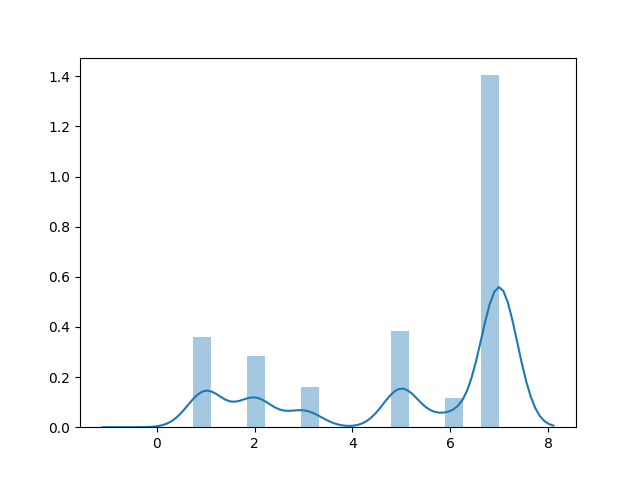

In [14]:
%matplotlib notebook 

import seaborn as sns 
import matplotlib.pyplot as plt 

sns.distplot(model.named_steps['kmeans'].labels_)

In [15]:
import numpy as np
from sklearn.cluster import SpectralClustering
from yellowbrick.cluster import SilhouetteVisualizer 

X = TfidfVectorizer().fit_transform([doc['Abstract'] for doc in corpus])

<IPython.core.display.Javascript object>


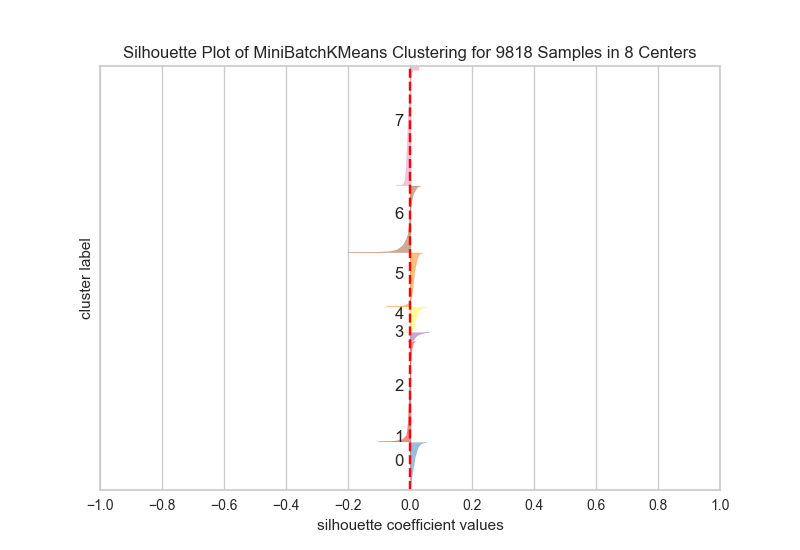

In [16]:
oz = SilhouetteVisualizer(MiniBatchKMeans())
oz.fit(X)
oz.poof()

In [19]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin 

class ColumnSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, column):
        self.column = column 
    
    def fit(self, X):
        return self 
        
    def transform(self, X):
        return [
            doc[self.column] for doc in X 
        ]


class Tokenizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, sep=";"):
        self.sep = sep 
    
    def fit(self, X):
        return self 
    
    def transform(self, X):
        return [
            {key: 1 for key in doc.split(self.sep)}
            for doc in X 
        ]

In [62]:
from sklearn.decomposition import TruncatedSVD 

model = Pipeline([
    ('cols', FeatureUnion([
        ('abstract', Pipeline([
            ('select', ColumnSelector('Abstract')),
            ('tfidf', TfidfVectorizer()), 
        ])),
        ('key terms', Pipeline([
            ('select', ColumnSelector('Author Keywords')),
            ('tokenize', Tokenizer()), 
            ('vect', DictVectorizer()), 
        ]))
    ])),
    ('svd', TruncatedSVD(1000))
])

docs = model.fit_transform(corpus)

In [64]:
docs[0].shape

(1000,)

## LDA

In [17]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [18]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [21]:
tfvec = CountVectorizer(strip_accents = 'unicode', stop_words = 'english', lowercase = True, token_pattern = r'\b[a-zA-Z]{3,}\b', max_df = 0.5, min_df = 10)
dtm_tf = tfvec.fit_transform(ColumnSelector('Abstract').fit_transform(corpus))

In [25]:
model = Pipeline([
    ('select', ColumnSelector('Abstract')),
    ('tfidf', TfidfVectorizer(**tfvec.get_params())),
    ('lda', LatentDirichletAllocation())
])

model.fit(corpus)

/Users/benjamin/.pyenv/versions/3.6.2/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Pipeline(memory=None,
     steps=[('select', ColumnSelector(column='Abstract')), ('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=10,
        ngram_range=(1, 1), ...ol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0))])

In [26]:
pyLDAvis.sklearn.prepare(model.named_steps['lda'], dtm_tf, tfvec)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      54.601350        1       1  0.115801  0.174529
1      39.418290        1       2  0.085876  0.118862
4       3.720637        1       3 -0.309895  0.083349
5       0.983179        1       4  0.001328 -0.160274
6       0.534836        1       5  0.028126 -0.073500
7       0.169456        1       6  0.017914 -0.036648
2       0.161225        1       7  0.018385 -0.034443
0       0.143796        1       8  0.014397 -0.024447
8       0.139297        1       9  0.014466 -0.025065
9       0.127932        1      10  0.013603 -0.022363, topic_info=     Category         Freq            Term        Total  loglift  logprob
term                                                                     
3238  Default  1890.000000     performance  1890.000000  30.0000  30.0000
3406  Default  1288.000000        presents  1288.000000  29.0000  29.0000
2643  Default  1161.000000             low  1161.000000  28.0000  28.0000
4906  Default  2710.000000         voltage  2710.000000  27.0000  27.0000
1053  Default   545.000000           cyber   545.000000  26.0000  26.0000
1192  Default  1400.000000          design  1400.000000  25.0000  25.0000
1508  Default  1755.000000          energy  1755.000000  24.0000  24.0000
2033  Default   705.000000        hardware   705.000000  23.0000  23.0000
3537  Default   763.000000        provides   763.000000  22.0000  22.0000
4369  Default   861.000000             sub   861.000000  21.0000  21.0000
326   Default   365.000000         attacks   365.000000  20.0000  20.0000
3403  Default  1402.000000       presented  1402.000000  19.0000  19.0000
2070  Default  1361.000000            high  1361.000000  18.0000  18.0000
4418  Default   647.000000             sup   647.000000  17.0000  17.0000
1041  Default  1314.000000         current  1314.000000  16.0000  16.0000
2762  Default   436.000000          memory   436.000000  15.0000  15.0000
635   Default   654.000000         circuit   654.000000  14.0000  14.0000
3276  Default   488.000000        physical   488.000000  13.0000  13.0000
1592  Default   655.000000          events   655.000000  12.0000  12.0000
2682  Default   893.000000      management   893.000000  11.0000  11.0000
2852  Default   849.000000            mode   849.000000  10.0000  10.0000
625   Default   505.000000            chip   505.000000   9.0000   9.0000
4056  Default   564.000000          sensor   564.000000   8.0000   8.0000
4765  Default  1054.000000            unit  1054.000000   7.0000   7.0000
4193  Default  1748.000000           smart  1748.000000   6.0000   6.0000
2451  Default   352.000000           issue   352.000000   5.0000   5.0000
3454  Default   903.000000         process   903.000000   4.0000   4.0000
4526  Default  1019.000000      technology  1019.000000   3.0000   3.0000
4125  Default  1250.000000          signal  1250.000000   2.0000   2.0000
1430  Default   635.000000      efficiency   635.000000   1.0000   1.0000
...       ...          ...             ...          ...      ...      ...
3937  Topic10     0.191145           round    35.549923   1.4358  -8.5196
2319  Topic10     0.191145      installing    78.191884   0.6475  -8.5196
1949  Topic10     0.191145         gigabit    34.970548   1.4522  -8.5196
3866  Topic10     0.191145  responsiveness    24.304036   1.8161  -8.5196
914   Topic10     0.191144      continuing    51.461017   1.0659  -8.5196
1441  Topic10     0.191144            eipp    35.439112   1.4389  -8.5196
1477  Topic10     0.191144      emphasized    34.955442   1.4526  -8.5196
3089  Topic10     0.191144         opposed    35.670826   1.4324  -8.5196
3407  Topic10     0.191144    preservation    23.903394   1.8327  -8.5196
4973  Topic10     0.191144           wires    25.468422   1.7693  -8.5196
1808  Topic10     0.191143            flat    48.609558   1.1229  -8.5196
4225  Topic10     0.191143         sorting    40.9831